In [6]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import math,re,os,json
import numpy as np
import pandas as pd

from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
from scipy.stats import linregress
import bezier as bz

import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/baltic/baltic.py')

typeface='Helvetica Neue'

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

def metricDistance(pointA,pointB):
    """ Calculate distance in kilometers along planet's surface from longitude and latitude. """
    R=6371 ## kilometers
    lon1,lat1=pointA
    lon2,lat2=pointB
    
    phi1=math.radians(lat1)
    phi2=math.radians(lat2)
    
    deltaPhi=math.radians(lat2-lat1)
    deltaLam=math.radians(lon2-lon1)
    
    a=math.sin(deltaPhi/2.0) * math.sin(deltaPhi/2.0) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLam/2.0) * math.sin(deltaLam/2.0)
    c = 2.0 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    
    return R*c

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate


In [7]:
colour_input=open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/plot/loc_data.txt','r')

locations=[]
location_to_country={}
normalized_coords={}
popCentres={}
colours={}
for line in colour_input:
    l=line.strip('\n').split('\t')
    if l[0]!='loc':
        loc,country,norm_coord,lon,lat,col=l
        if country in ['SLE','GIN','LBR']:
            locations.append(loc)
            location_to_country[loc]=country
            normalized_coords[loc]=float(norm_coord)
            popCentres[loc]=(float(lon),float(lat))
            colours[loc]=col
        
location_to_country['WesternArea']='SLE'
normalized_coords['WesternArea']=normalized_coords['WesternUrban']
popCentres['WesternArea']=popCentres['WesternUrban']
colours['WesternArea']=colours['WesternUrban']

path_to_dropbox='/Users/evogytis/Dropbox/Ebolavirus_Phylogeography/'
map_path=path_to_dropbox+'Data_Processing/June2016/'
filenames=['location_data_v3.geojson']
location_points={}
polygons={}
for fname in filenames: ## iterate through country files
    handle=json.load(open(map_path+fname,'r')) ## load data
    features=handle['features']

    for loc in features: ## iterate through features (locations)
        poly = np.array(loc['geometry']['coordinates']) ## get coordinates
        country=loc['properties']['ISO']
        location=loc['properties']['location'] ## standardised location name

        if country in ['SLE','GIN','LBR']:
            polygons[location]=[]
            location_points[location]=[]
            if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
                for part in poly:
                    for coords in part:
                        xs,ys=zip(*coords)
                        location_points[location].append(np.vstack(zip(xs,ys)))
            if loc['geometry']['type']=='Polygon': ## location is single part
                for coords in poly:
                    xs,ys=zip(*coords)
                    location_points[location].append(np.vstack(zip(xs,ys)))

            complete_location=[]
            for part in location_points[location]:
                complete_location.append(Polygon(part,True))

            polygons[location]=complete_location

standard=path_to_dropbox+'Maps/standardDistricts.tsv'
map_to_actual={}
for line in open(standard,'r'):
    l=line.strip('\n').split('\t')
    ## map parts of a district name to its standard name
    # split by space, keep last word in lower case
    # e.g River Gee = gee, Grand Cape Mount = mount.
    actual=l[1]
    if 'actual' not in actual:
        actual=actual.decode('utf8')
        map_to_actual[l[-1]]=actual
        
summary={'genome':{'length':18992},
         'gp':{'length':2031}}

This cell loads the 60 taxa designated for masking.

In [8]:
mask=[]
for line in open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/masked_set.txt','r'):
    l=line.strip('\n')
    mask.append(l)
    
subset=[]
for line in open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/alignments/Makona_600_gp.fasta','r'):
    if '>' in line:
        subset.append(line.strip('\n')[1:])

print 'Done!'

Done!


Load posterior distributions of parameters.

In [9]:
# log_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.log'%(i) for i in range(5)]
# log_paths+=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.log'%(i) for i in range(5)]
log_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.log'%(i) for i in range(3)]
log_paths+=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.log'%(i) for i in range(3,10)]

data={}
burnin=50000000

for log_path in log_paths:
    if 'genome' in log_path:
        log='genome'
    else:
        log='gp'
    
    for line in open(log_path,'r'):
        if '#' not in line:
            l=line.strip('\n').split('\t')
            if l[0]=='state':
                header=l
                if data.has_key(log)==False:
                    data[log]={x:[] for i,x in enumerate(header)}
            elif len(l)==len(header) and int(l[0])>burnin:
                for i,x in enumerate(l):
                    if 'age(' in header[i]:
                        data[log][header[i]].append(2016.0-float(x))
                    elif 'ucld' in header[i] or 'meanRate' in header[i]:
                        data[log][header[i]].append(float(x))
                        
                    if header[i] in ['state','prior','likelihood','posterior']:
                        data[log][header[i]].append(float(x))

for x in data.keys():
    print x,len(data[x]['ucld.mean']),np.mean(data[x]['meanRate'])*1e3
    summary[x]['rate']=np.mean(data[x]['meanRate'])
    summary[x]['rate lower 95\% HPD'],summary[x]['rate upper 95\% HPD']=hpd(data[x]['meanRate'],0.95)

genome 4330 0.9801089699842608
gp 38855 1.5948946150738836


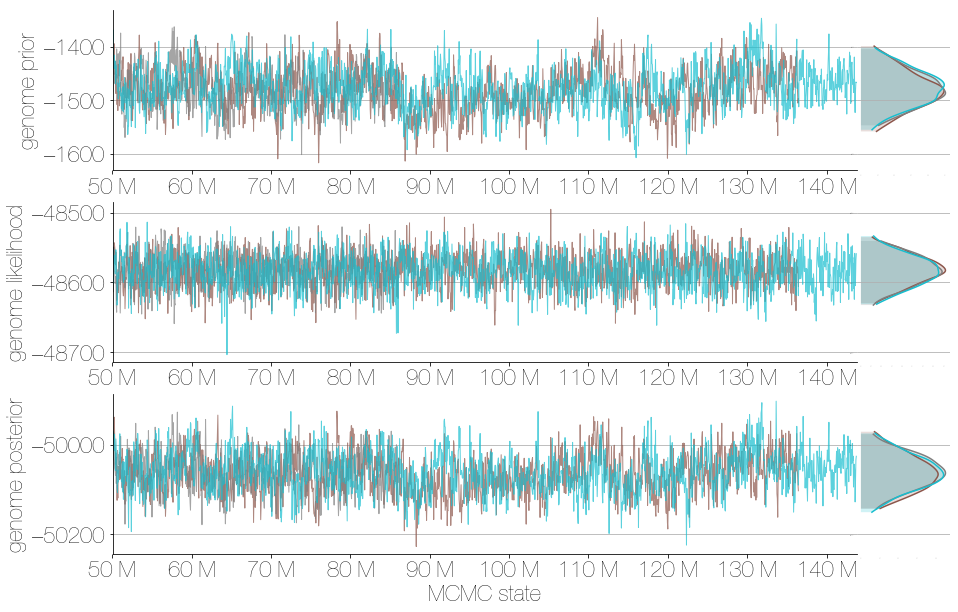

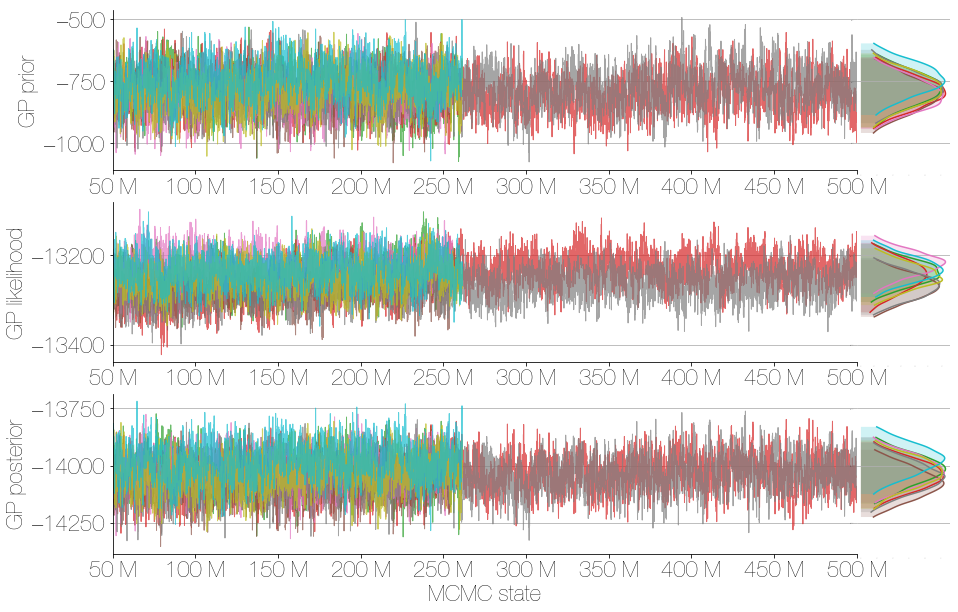

In [10]:
for idx,log in enumerate(data):
    fig = plt.figure(figsize=(15, 10),facecolor='w') 
    gs = gridspec.GridSpec(3, 2,width_ratios=[8,1],wspace=0.0,hspace=0.2) ## setup figure with two columns
    
    for p,param in enumerate(['prior','likelihood','posterior']):
        ax = plt.subplot(gs[p,0])
        ax2 = plt.subplot(gs[p,1])

        states=data[log]['state']
        stat=data[log][param]
        
        breaks=[-1]
        breaks+=[i for i in range(len(states)-1) if (states[i+1]-states[i])<0]
        breaks.append(len(states)-1)
        
        for m,mcmc in enumerate(zip(breaks,breaks[1:])):
            start,stop=mcmc
            
            if log=='genome':
                f=(m+2)/4.0
            elif log=='gp':
                f=(m+2)/8.0
            colour=mpl.cm.tab10(f)

            x_grid=states[start+1:stop]
            y_grid=stat[start+1:stop]
            
            alpha=0.2
            ax.plot(x_grid,y_grid,color=colour,alpha=0.7,lw=1)
            
            kde=gaussian_kde(y_grid)
            hpdLo,hpdHi=hpd(y_grid,0.95)
            val_range=np.linspace(hpdLo,hpdHi,100)
            ax2.fill_betweenx(val_range,kde(val_range),facecolor=colour,alpha=alpha)
            ax2.plot(kde(val_range),val_range,color=colour)

        if log=='genome':
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1e7))
            ax.set_ylabel('genome %s'%(param))
        elif log=='gp':
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5e7))
            ax.set_ylabel('GP %s'%(param))
            
        if p==2:
            ax.set_xlabel('MCMC state')
        
        ax.grid(axis='y')
        ax2.grid(axis='y')
        
        ax2.tick_params(size=0,labelsize=0)
        ax2.set_yticks(ax.get_yticks())
        
        ax.set_xlim(min(states),max(states))
        ax2.set_ylim(ax.get_ylim())
        
        ax.xaxis.set_major_formatter(mpl.ticker.EngFormatter())
        [ax.spines[loc].set_visible(False) for loc in ['top','right']]
        [ax2.spines[loc].set_visible(False) for loc in ax2.spines]
        
    plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/supp_figures/sfigX_%s_mcmc.png'%(log),dpi=300,bbox_inches='tight')
    plt.show()

Load MCC trees.

In [11]:
gp_mcc=bt.loadNexus('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/xml/combined/Makona_600_gp.GLM.mcc.tree')
gn_mcc=bt.loadNexus('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/xml/combined/Makona_600_genome.GLM.mcc.tree')

gp_mcc.treeStats()
gn_mcc.treeStats()

gp_ml=bt.tree()
gn_ml=bt.tree()
bt.make_tree(open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/trees/Makona_600_gp.rooted.tree','r').readline(),gp_ml)
bt.make_tree(open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/trees/Makona_600_genome.rooted.tree','r').readline(),gn_ml)
gp_ml.renameTips({k.numName:k.numName for k in gp_ml.Objects if k.branchType=='leaf'})
gn_ml.renameTips({k.numName:k.numName for k in gn_ml.Objects if k.branchType=='leaf'})

gp_ml.root.children[-1].length=0.0
gn_ml.root.children[-1].length=0.0

gp_ml.sortBranches()
gn_ml.sortBranches()
gp_ml.treeStats()
gn_ml.treeStats()

summary['genome']['ML tree length']=sum(gn_ml.getParameter('length',use_trait=False))
summary['gp']['ML tree length']=sum(gp_ml.getParameter('length',use_trait=False))

summary['genome']['timetree length']=sum(gn_mcc.getParameter('length',use_trait=False))
summary['gp']['timetree length']=sum(gp_mcc.getParameter('length',use_trait=False))


Tree height: 1.980173
Tree length: 173.017810
strictly bifurcating tree
annotations present

Numbers of objects in tree: 1199 (600 nodes and 599 leaves)


Tree height: 1.794622
Tree length: 80.299264
strictly bifurcating tree
annotations present

Numbers of objects in tree: 1199 (600 nodes and 599 leaves)


Tree height: 0.003530
Tree length: 0.080270
annotations present

Numbers of objects in tree: 642 (43 nodes and 599 leaves)


Tree height: 0.001700
Tree length: 0.067770
annotations present

Numbers of objects in tree: 810 (211 nodes and 599 leaves)



Load pre-computed **actual** HPD intervals (not computed assuming single normally distributed peak) for tip ages.

In [12]:
tip_ages={'gp':{},
          'genome':{}}

for gene in ['gp','genome']:
    for line in open('/Users/evogytis/Documents/manuscripts/genomic-horizon/data/plot/%s_ageHPDS.txt'%(gene),'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='tip':
            pass
        else:
            tipName,intervals,integral=l
            integral=float(integral)
            intervals=[map(float,frag.split('-')) for frag in intervals.split(',')]
            
            tip_ages[gene][tipName]=intervals
            
print 'Done!'

Done!


genome SpearmanrResult(correlation=0.91869286450324, pvalue=4.515909520500209e-25) LinregressResult(slope=0.960338121533059, intercept=79.91064800470008, rvalue=0.958697712318355, pvalue=2.324565632933157e-33, stderr=0.03741099360300732)
genome correct: 0.93 56 4 60
genome mean waiting time for mutation: 19.61 days
genome mean error: 0.300 days (mean absolute error: 21.733 days)
genome precision: 102.287 days
GP SpearmanrResult(correlation=0.1060105041613944, pvalue=0.4201532850801012) LinregressResult(slope=0.20824077396317883, intercept=1595.2288535045968, rvalue=0.23194816292781842, pvalue=0.07454152566349063, stderr=0.11467066168904194)
GP correct: 0.98 59 1 60
GP mean waiting time for mutation: 112.68 days
GP mean error: 8.012 days (mean absolute error: 105.929 days)
GP precision: 458.386 days


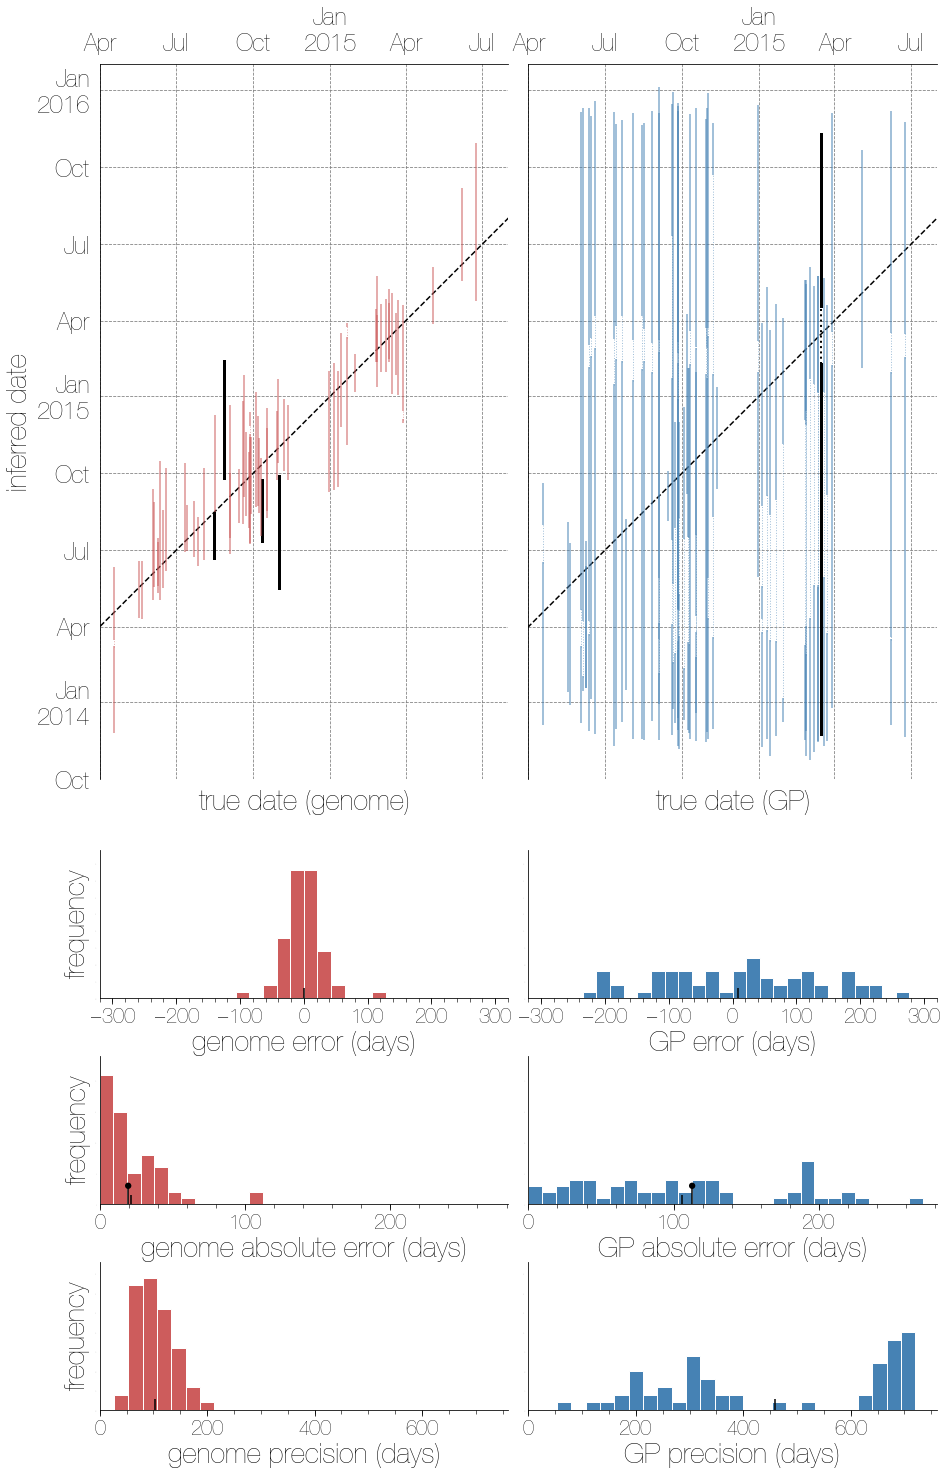

In [13]:
every=3
all_mons=['2013-%02d-01'%(x) for x in range(10,13,1)]
all_mons+=['2014-%02d-01'%(x) for x in range(1,13,1)]
all_mons+=['2015-%02d-01'%(x) for x in range(1,13,1)]
all_mons+=['2016-%02d-01'%(x) for x in range(1,3,1)]
mons=[x for x in all_mons if (int(x.split('-')[1])-1)%every==0]

x_range=bt.decimalDate('2015-08-01')-bt.decimalDate('2014-04-01')
y_range=bt.decimalDate(all_mons[-1])-bt.decimalDate(all_mons[0])

fig = plt.figure(figsize=(15, 25),facecolor='w') 
gs = gridspec.GridSpec(4, 2,height_ratios=[5,1,1,1],wspace=0.05,hspace=0.195) ## setup figure with two columns

locTrait='location.states'

for i,T in enumerate(data.keys()):
    ax = plt.subplot(gs[0,i])
    ax2 = plt.subplot(gs[1,i])
    ax3 = plt.subplot(gs[2,i])
    ax4 = plt.subplot(gs[3,i])
    
    if 'genome' in T:
        fc='indianred'
        gene='genome'
        aln=gene
        ll=gn_mcc
    else:
        fc='steelblue'
        gene='gp'
        aln=gene.upper()
        ll=gp_mcc
    
    out=open('/Users/evogytis/Downloads/Fig2_dates_%s.tsv'%(T),'w')
    correct=[]
    distances=[]
    test_x=[]
    test_y=[]
    
    precisions=[]
    
    for tipName in tip_ages[gene].keys():
        tip=[k for k in ll.Objects if k.branchType=='leaf' and k.name==tipName][-1]
        date=tipName.split('|')[-1]
        true_date=bt.decimalDate(date)

        inferred_date=data[T]['age(%s)'%(tipName)] ## fetch posterior distribution

        test_x.append(true_date)
        test_y.append(np.mean(inferred_date))
        
        inferred_loc={x:y for x,y in zip(tip.traits['%s.set'%(locTrait)],tip.traits['%s.set.prob'%(locTrait)])}
        distances.append((true_date-np.mean(inferred_date))*365.0) ## calculate difference between mean inferred date and true data, convert to days
        
        al=1.0
        lw=3
        c='k'
        within=False
        precision=0.0
        for i,interval in enumerate(tip_ages[gene][tipName]): ## iterate over 95% HPD intervals recovered
            start,end=interval
            precision+=(end-start)*365.0 ## get span for every interval, convert to days
            if start<=true_date<=end:
                al=0.5
                lw=2
                c=fc
                within=True
        precisions.append(precision)
        
        out.write('%s\t%s\t%s\t%s\t%s\n'%(tipName,true_date,np.mean(inferred_date),tip_ages[gene][tipName],within))
        if al==0.5:
            correct.append(1)
        elif al==1.0:
            correct.append(0)

        for i,interval in enumerate(tip_ages[gene][tipName]):
            ax.plot([true_date,true_date],interval,color=c,lw=lw,alpha=al,zorder=98)

            if i<len(tip_ages[gene][tipName])-1:
                ax.plot([true_date,true_date],[interval[-1],tip_ages[gene][tipName][i+1][0]],lw=lw-1,ls=':',color=c,alpha=al,zorder=97)
    
    print aln,spearmanr(test_x,test_y),linregress(test_x,test_y)
    out.close()
    ax.set_xticks(map(bt.decimalDate,mons))
    ax.set_yticks(ax.get_xticks())
    ax.set_xticklabels([bt.convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else bt.convertDate(x,'%Y-%m-%d','%b') for x in mons])

    ax.set_xlim(bt.decimalDate('2014-04-01'),bt.decimalDate('2015-08-01'))
    ax.set_ylim(bt.decimalDate(all_mons[0]),bt.decimalDate(all_mons[-1]))

    ax.plot([2012.0,2018.0],[2012.0,2018.0],ls='--',color='k')
    if i==0:
        ax.set_ylabel('inferred date',size=28)
        ax.set_yticklabels(ax.get_xticklabels())
        ax2.set_ylabel('frequency',size=28)
        ax3.set_ylabel('frequency',size=28)
        ax4.set_ylabel('frequency',size=28)
    else:
        ax.set_yticklabels([])

    ax.grid(ls='--',color='grey')
    
    ax.xaxis.labelpad=10
    ax.set_xlabel('true date (%s)'%(aln),size=28)
    ax.xaxis.tick_top()
    ax.set_aspect(1)
    print '%s correct: %.2f %d %d %d'%(aln,np.mean(correct),correct.count(1),correct.count(0),len(correct))
    
    mean_d=np.mean(distances)
    ax2.hist(distances,range=(-320,320),bins=30,facecolor=fc,edgecolor='w')
    ax2.eventplot([mean_d],color=['k'],linelengths=3,lineoffsets=0,zorder=100)
    ax2.set_xlim(-320,320)
    
    mean_ad=np.mean(map(abs,distances))
    ax3.hist(map(abs,distances),range=(0,281),bins=30,facecolor=fc,edgecolor='w')
    ax3.eventplot([mean_ad],color=['k'],linelengths=3,lineoffsets=0,zorder=100)
    ax3.set_xlim(0,281)
    if aln=='GP':
        expectation=1/(2031*0.0015948946150738837)*365
    elif aln=='genome':
        expectation=1/(18992*0.0009801089699842608)*365
    
    print('%s mean waiting time for mutation: %.2f days'%(aln,expectation))
    ax3.eventplot([expectation],color=['k'],linelengths=6,lineoffsets=0,zorder=100)
    ax3.scatter(expectation,3,s=40,facecolor='k',edgecolor='none',zorder=101)
    
    mean_p=np.mean(precisions)
    ax4.hist(precisions,range=(0,800),bins=30,facecolor=fc,edgecolor='w')
    ax4.eventplot([mean_p],color=['k'],linelengths=3,lineoffsets=0,zorder=100)
    ax4.set_xlim(0,760)
    
    print '%s mean error: %.3f days (mean absolute error: %.3f days)'%(aln,mean_d,np.mean(map(abs,distances)))
    print '%s precision: %.3f days'%(aln,mean_p)
    summary[aln.lower()]['mean error']=mean_d
    summary[aln.lower()]['mean absolute error']=np.mean(map(abs,distances))
    summary[aln.lower()]['precision']=mean_p
    summary[aln.lower()]['expected waiting time for mutation']=expectation
    
    ax2.set_xlabel('%s error (days)'%(aln),size=28,clip_on=False)
    ax3.set_xlabel('%s absolute error (days)'%(aln),size=28,clip_on=False)
    ax4.set_xlabel('%s precision (days)'%(aln),size=28,clip_on=False)

    [ax.spines[pos].set_color('none') for pos in ['bottom','right']]
    [ax2.spines[pos].set_color('none') for pos in ['right','top']]
    [ax3.spines[pos].set_color('none') for pos in ['right','top']]
    [ax4.spines[pos].set_color('none') for pos in ['right','top']]

    ax.tick_params(size=0,labelsize=24,pad=10)
    
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    ax2.tick_params(axis='x',which='major',size=6,labelsize=20)
    ax2.tick_params(axis='x',which='minor',size=4,labelsize=0)
    ax2.tick_params(axis='y',size=0,labelsize=0)
    ax2.set_ylim(0,22)
    
    ax3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
    ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    ax3.tick_params(axis='x',which='major',size=6,labelsize=20)
    ax3.tick_params(axis='x',which='minor',size=4,labelsize=0)
    ax3.tick_params(axis='y',size=0,labelsize=0)
    ax3.set_ylim(0,24)
    
    ax4.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
    ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    ax4.tick_params(axis='x',which='major',size=6,labelsize=20)
    ax4.tick_params(axis='x',which='minor',size=4,labelsize=0)
    ax4.tick_params(axis='y',size=0,labelsize=0)
    ax4.set_ylim(0,19)
plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/fig2_dates.png',dpi=300,bbox_inches='tight')
plt.show()

60

genome
predicted accuracy (mean of best guess probabilities): 0.680
cross entropy: 6054.631 nats (assigning 0.0001 probability when true location has 0.0 probability)
incorrect (true location not in 95% highest probability set): 7
correct (true location == predicted): 0.540
mean prob of correct location: 0.482
mean probability-weighed distance between inferred and correct population centroids: 75.886 km


GP
predicted accuracy (mean of best guess probabilities): 0.396
cross entropy: 9905.726 nats (assigning 0.0001 probability when true location has 0.0 probability)
incorrect (true location not in 95% highest probability set): 5
correct (true location == predicted): 0.286
mean prob of correct location: 0.219
mean probability-weighed distance between inferred and correct population centroids: 164.309 km



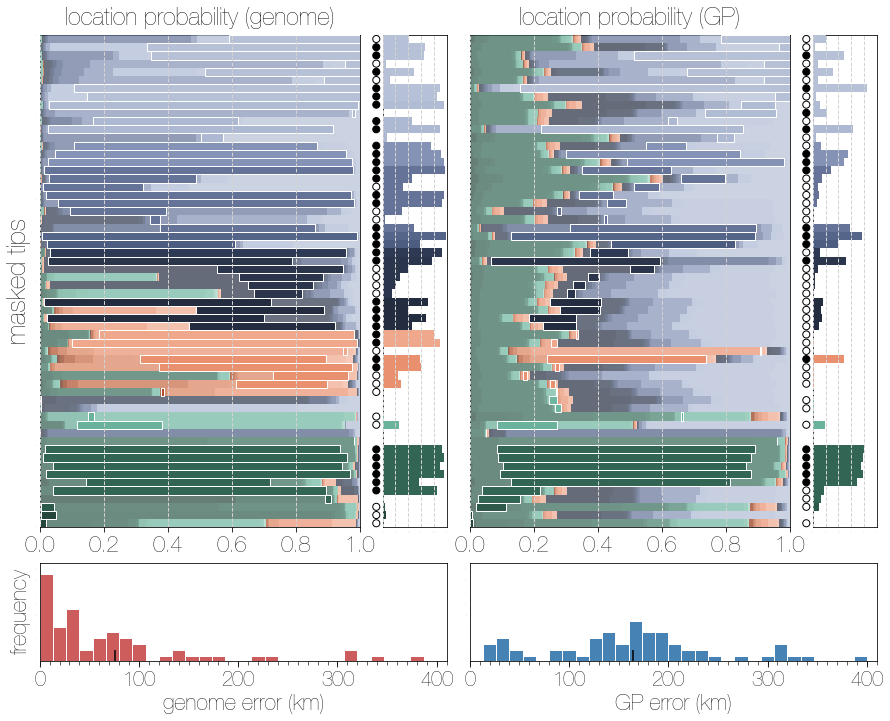

In [14]:
fig = plt.figure(figsize=(15, 15),facecolor='w') 

L=len(data)
L=2

gs = gridspec.GridSpec(2, 2*L,height_ratios=[5,1],width_ratios=[5,1]*L,wspace=0.12,hspace=0.12,bottom=0.3) ## setup figure with two columns

masked_tip_names=[x.split('age(')[-1][:-1] for x in data.values()[0] if 'age(' in x]
print len(masked_tip_names)

locTrait='location.states'
calibration={0:[],1:[]} ## will contain data for calibration later

for idx,ll in enumerate([gn_mcc,gp_mcc]): ## iterate over genome and GP trees
    D=[]
    ax = plt.subplot(gs[0,idx*L]) ## probabilities
    ax1 = plt.subplot(gs[0,idx*L+1]) ## one probability
    ax2 = plt.subplot(gs[1,idx*L:idx*L+2]) ## KDEs

    i=0
    entropy=0.0
    inf=0

    correctCount=0
    max_guesses=[] ## keep track of how confident model is about the most likely location
    correct=[]
    masked_tips=[w for w in ll.Objects if w.branchType=='leaf' and '?' not in w.name.split('|')[4]]
    
    truths=[]
    predicts=[]
    
    if idx==0:
        ax.set_ylabel('masked tips',size=26)
        label='genome'
    else:
        label='GP'
    
    out=open('/Users/evogytis/Downloads/Fig3_locations_%s.tsv'%(label),'w')
    out.write('tip\tloc\tloc prob\t%s\tin 95 set\n'%(' prob\t'.join(sorted(locations,key=lambda q:(location_to_country[q],-normalized_coords[q])))))
    for k in sorted(masked_tips,key=lambda q:(location_to_country[q.name.split('|')[4]],-normalized_coords[q.name.split('|')[4]],q.name)): ## iterate over tips
    
        if data.values()[0].has_key('age(%s)'%(k.name)): ## if tip masked
            d=[] ## start new list for distances
            true_loc=k.name.split('|')[4] ## get correct location
            if true_loc=='WesternArea':
                true_loc='WesternUrban'
            true_coord=popCentres[true_loc] ## get population centroid for correct location

            inferred={x:y for x,y in zip(k.traits['%s.set'%(locTrait)],k.traits['%s.set.prob'%(locTrait)])} ## create dictionary of posterior guesses
            
            for loc in locations: ## iterate through all locations
                if loc not in inferred: ## if missing - assign probability 0
                    inferred[loc]=0.0
            
            sorted_set=sorted(inferred.keys(),key=lambda x:-inferred[x]) ## sort states according to probability from highest to lowest
            sorted_probs=[inferred[x] for x in sorted_set] ## get probabilities
            
            if sorted_probs[0]>0.95:
                mostProbableSet=[sorted_set[0]]
            else:
                mostProbableSet=[sorted_set[x] for x in range(len(sorted_set)) if sum(sorted_probs[:x+1])<0.95] ## cumulative sum of probabilities until you hit 95% or if first state is >95%
            
            inSet=true_loc in mostProbableSet ## bool: is true location in the 95% set?
            
            if inSet:
                ax1.scatter(-0.1,i+0.5,s=50,edgecolor='k',facecolor='none',clip_on=False)
            
            if inferred.has_key(true_loc) and inSet: ## if correct location not among guesses
                correct.append(inferred[true_loc]) ## add probability to list
            else:
                inf+=1
                correct.append(0.0) ## add zero otherwise
            
            max_guesses.append(max(inferred.values())) ## log best guess
            bestGuess=[w for w in inferred if inferred[w]==max(inferred.values())][-1] ## get best guess
            
            if bestGuess==true_loc: ## count if best guess is correct
                correctCount+=1
                calibration[idx].append((inferred[bestGuess],1)) ## log probability, 1 for correct
                ax1.scatter(-0.1,i+0.5,s=50,edgecolor='none',facecolor='k',clip_on=False)
            else:
                calibration[idx].append((inferred[bestGuess],0)) ## log probability, 0 for incorrect
                
            out.write('%s\t%s\t%s\t%s\t%s\n'%(k.name,true_loc,inferred[true_loc],'\t'.join([str(inferred[w]) for w in sorted(locations,key=lambda q:(location_to_country[q],-normalized_coords[q]))]),inSet))
            p=0.0
            tip_distance=0.0
            for loc in sorted(locations,key=lambda q:(location_to_country[q],-normalized_coords[q])): ## iterate over all locations
                prob=inferred[loc] ## get probability of guess
                infer_coord=popCentres[loc] ## get coordinate of guess
                distance=metricDistance(true_coord,infer_coord)*prob ## multiply pop centroid distance by guess probability
#                 d.append(distance) ## remember guess distance
                tip_distance+=distance
                fc=colours[loc] ## get colour
                ec='none'

                h=''
                al=0.7
                w=1.0
                    
                if loc==true_loc: ## if guess is correct - change visuals
                    al=1.0
                    
                    ax1.add_patch(plt.Rectangle((0.0,i),prob,w,facecolor=fc,edgecolor=ec,
                                           hatch=h,alpha=al,zorder=int(al*10)))
                    ax1.plot()
                    h=''
                    ec='w'
        
                if inferred.has_key(true_loc): ## compute cross entropy
                    entropy+=-np.log(inferred[true_loc]+0.0001)
                else:
                    entropy+=-np.log(0.0001) ## avoid domain error

                ax.add_patch(plt.Rectangle((p,i),prob,w,facecolor=fc,edgecolor=ec,
                                           hatch=h,alpha=al,zorder=int(al*10))) ## add patch for every location
                p+=prob
            
            d.append(tip_distance)
            i+=1 ## next tip
            D+=d ## add distances to complete list
    out.close()
    ax.set_ylim(0,len(masked_tip_names))
    
    ax.set_xticks(np.linspace(0.0,1.0,6))
    ax1.set_xticks(np.linspace(0.0,1.0,6))
    
    [ax.axvline(x,lw=1,ls='--',color='lightgrey',zorder=10) for x in ax.get_xticks()]
    [ax1.axvline(x,lw=1,ls='--',color='lightgrey',zorder=10) for x in ax1.get_xticks()]
    
    ax1.set_ylim(ax.get_ylim())
    ax.tick_params(axis='y',size=0,labelsize=0)
    ax.tick_params(axis='x',size=5,labelsize=22)
    ax1.tick_params(size=0,labelsize=0)
    
    

    ax.set_xlim(0,1)
    ax1.set_xlim(ax.get_xlim())
    print '\n%s\npredicted accuracy (mean of best guess probabilities): %.3f\ncross entropy: %.3f nats (assigning 0.0001 probability when true location has 0.0 probability)\nincorrect (true location not in 95%% highest probability set): %d\ncorrect (true location == predicted): %.3f\nmean prob of correct location: %.3f\nmean probability-weighed distance between inferred and correct population centroids: %.3f km\n'%(label,np.mean(max_guesses),entropy,inf,correctCount/float(len(locations)),np.mean(correct),np.mean(D))
    
    summary[label.lower()]['location cross entropy']=entropy
    summary[label.lower()]['weighted location error']=np.mean(D)
    summary[label.lower()]['correct location guess']=correctCount/float(len(locations))
    
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad=10.0
    ax.set_xlabel('location probability (%s)'%(label),size=24)
    
    if idx==0:
        fc='indianred'
        ax2.set_ylabel('frequency',size=22)
    else:
        fc='steelblue'
    
    ax2.hist(D,facecolor=fc,edgecolor='w',bins=30,range=(0,400))
    
    ax2.eventplot([np.mean(D)],color=['k'],lineoffsets=0,linelengths=4,zorder=100)
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    ax2.set_xlim(0,410)
    ax2.set_ylim(0,17)
    ax2.set_xlabel('%s error (km)'%(label),size=22)
    ax2.tick_params(axis='y',size=0,labelsize=0)
    ax2.tick_params(axis='x',labelsize=20,size=6)
    ax2.tick_params(axis='x',size=4,which='minor')
    
plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/fig3_locations.png',dpi=300,bbox_inches='tight')
plt.show()

0
genome accuracy: 0.667
1
GP accuracy: 0.783


/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


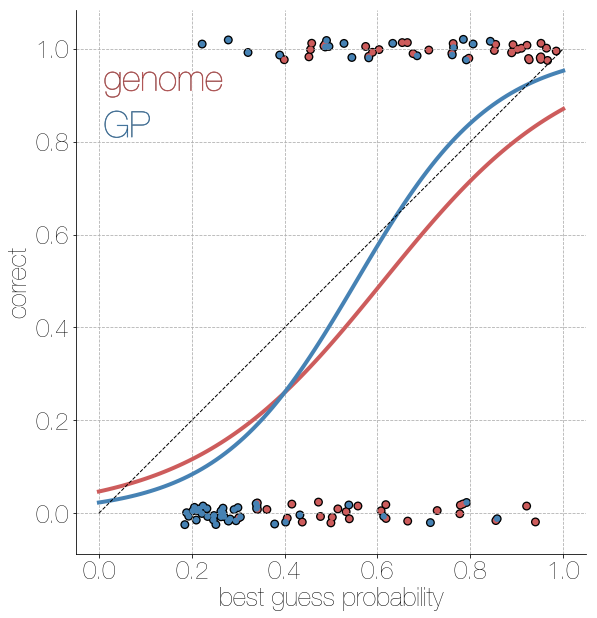

In [15]:
fig = plt.figure(figsize=(10,10),facecolor='w') 
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0])

from sklearn.linear_model import LogisticRegression

for idx in calibration:
    print idx
    c=['indianred','steelblue'][idx]
    
    xs,ys=np.array(calibration[idx]).T
    jitter=[y+np.random.uniform(-0.025,0.025) for y in ys]
    ax.scatter(xs,jitter,s=40,facecolor=c,edgecolor='none',alpha=1.0,zorder=2)
    ax.scatter(xs,jitter,s=80,facecolor='k',edgecolor='none',alpha=1.0,zorder=1)
    
    Xs=np.array(xs).reshape(-1,1)
    grid=np.linspace(0,1,100).reshape(-1,1)
    
    clf = LogisticRegression(fit_intercept=True,C=10000.0).fit(Xs, ys)
#     res=clf.predict(X)
    res=clf.predict_proba(grid)
    
    if idx==0:
        label='genome'
    else:
        label='GP'
    
    print '%s accuracy: %.3f'%(label,clf.score(Xs,ys))
    ax.plot(grid,res[:,1],color=c,ls='-',lw=4)
    
    effects=[path_effects.Stroke(linewidth=3, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground=c)]
    ax.text(0.01,0.91-idx*0.1,label,size=36,path_effects=effects)
    
ax.set_xlabel('best guess probability',size=26)
ax.set_ylabel('correct',size=26)
ax.tick_params(labelsize=24)
ax.plot([0.0,1],[0.0,1],color='k',ls='--',lw=1)
ax.grid(ls='--')
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom','left']]
ax.set_aspect(1)

plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/sfigX_calibration.png',dpi=300,bbox_inches='tight')
plt.show()

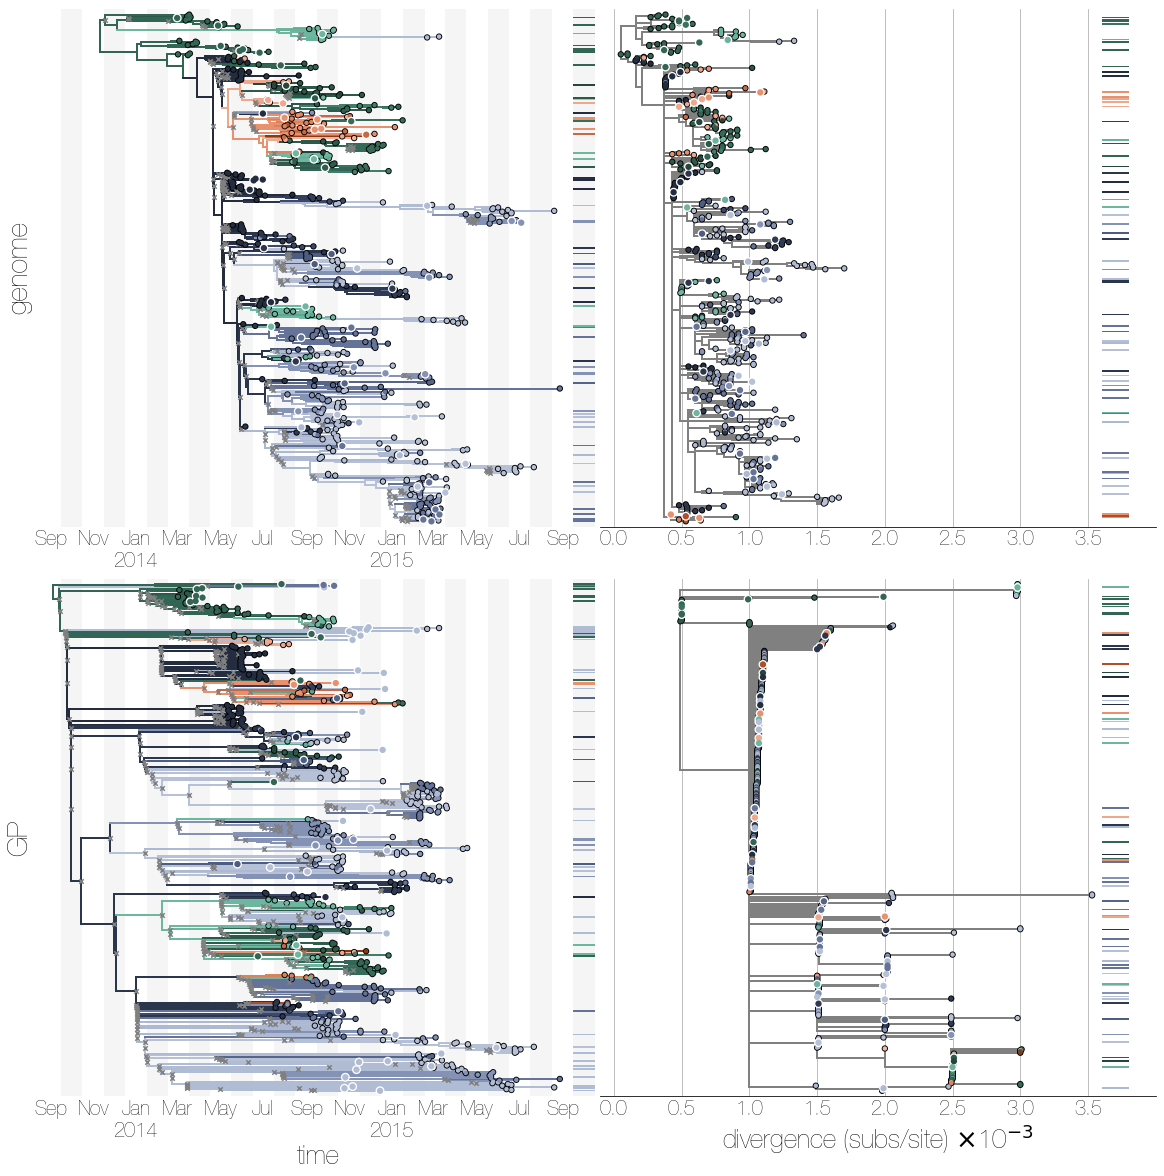

In [16]:
locTrait='location.states'

fig = plt.figure(figsize=(20, 20),facecolor='w') 
gs = gridspec.GridSpec(2, 2,wspace=0.01,hspace=0.1) ## setup figure with two columns

branchWidth=2 ## line width for branches

for idx,ll in enumerate([gn_mcc,gn_ml,gp_mcc,gp_ml]):
    if idx==3:
#         ax = plt.subplot(gs[idx],sharex=plt.subplot(gs[1]))
        ax = plt.subplot(gs[idx])
    else:
        ax = plt.subplot(gs[idx])
    
    plot_tree=ll ## reference
    if idx<2:
        gene='genome'
        aln=gene
    else:
        gene='gp'
        aln=gene.upper()
    
    for k in plot_tree.Objects: ## iterate over branches in the tree
        x=k.height
        xp=k.parent.height
        if idx%2==0:
            location=k.traits[locTrait] ## get inferred location of branch
            c=colours[location] ## get colour of location
            tc=c
            x=k.absoluteTime ## x coordinate is absolute time
            xp=k.parent.absoluteTime ## get parent's absolute time
        elif k.branchType=='leaf':
            location=k.name.split('|')[4]
            c='grey'
            tc=colours[location]
        else:
            c='grey'
            
        y=k.y ## get y coordinates
        yp=k.parent.y ## get parent's y coordinate
        
        if 'posterior' in k.traits and k.traits['posterior']<0.10:
            ax.scatter(x,y,s=20,facecolor='grey',marker='x',zorder=99)

        z=0
        ec='k'
        tipSize=20 ## tip circle radius
        if k.branchType=='leaf':
            loc=k.name.split('|')[4]
            if k.name in tip_ages[gene]:
                ec='w'
                tipSize=40
                z=2
            elif loc=='?' or len(k.name.split('|')[-1].split('-'))<3:
                ec='w'
                tipSize=10

        if k.branchType=='leaf': ## if tip...
            ax.scatter(x,y,s=tipSize,facecolor=tc,edgecolor='none',zorder=100+z) ## put a circle at each tip
            ax.scatter(x,y,s=tipSize*2,facecolor=ec,edgecolor='none',zorder=99+z)

            if k.name in tip_ages[gene]:
                if idx%2==0:
#                     ax.plot([x,bt.decimalDate('2015-10-01')],[y,y],ls='--',color=c,zorder=90)
                    ax.add_patch(plt.Rectangle((bt.decimalDate('2015-10-01'),y-0.5),1.0,2.0,facecolor=c,edgecolor='none',zorder=100+z))
                else:
#                     ax.plot([x,0.0038],[y,y],ls='--',color=tc,zorder=90)
                    ax.add_patch(plt.Rectangle((0.0036,y-0.5),0.0002,2.0,facecolor=tc,edgecolor='none',zorder=100+z))

        elif k.branchType=='node': ## if node...
            yl=k.children[0].y ## get y coordinates of first and last child
            yr=k.children[-1].y

            if xp==0.0:
                xp=x

            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98) ## plot vertical bar connecting node to both its offspring

        ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot horizontal branch to parent

    ax.xaxis.tick_bottom() ## tick bottom
    ax.yaxis.tick_left() ## tick left

    xDates=['2013-%02d-01'%x for x in range(8,13)] ## create a timeline centered on each month
    xDates+=['2014-%02d-01'%x for x in range(1,13)]
    xDates+=['2015-%02d-01'%x for x in range(1,11)]
    every=2
    if idx%2==0: ## time trees
#         ax.xaxis.set_label_position('top')
        ax.set_ylabel(aln,size=28)
        [ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)] ## grey vertical bar every second month
        ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0]) ## x ticks in the middle of each month
        ax.set_xticklabels([bt.convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else bt.convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0]) ## labels in mmm format unless January: then do YYYY-mmm
        ax.set_xlim(bt.decimalDate('2013-09-01'),bt.decimalDate('2015-11-01')) ## bounds on axis limits
        [ax.spines[side].set_visible(False) for side in ['top','bottom','left','right']] ## make axes invisible
        if idx>1:
            ax.set_xlabel('time',size=26)
    else:
        ax.set_xticks(np.arange(0.000,0.004,0.0005))
        ax.set_xticklabels([q*1e3 for q in ax.get_xticks()])
        ax.set_xlim(-0.0001,0.004)
#         if gene=='genome':
#             ax.set_xlim(-0.0001,plot_tree.treeHeight*1.1)
        if gene=='gp':
#             ax.set_xlim(-0.0001,plot_tree.treeHeight*1.1)
            ax.set_xlabel(r'divergence (subs/site) $\times$10$^{-3}$',size=26)
            
        [ax.spines[side].set_visible(False) for side in ['top','left','right']]
        ax.grid(axis='x')
        
    ax.tick_params(axis='x',labelsize=20,size=0) ## no axis labels visible except for timeline
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])
    
    ax.set_ylim(-6,plot_tree.ySpan+6)
plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/fig1_trees.png',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
## compute Robinson-Foulds distance
from ete3 import Tree

remap_tip_names={k.name: k.numName for k in gn_mcc.getExternal()}

for k in gn_ml.getExternal():
    k.name=remap_tip_names[k.numName]
for k in gp_ml.getExternal():
    k.name=remap_tip_names[k.numName]
        
gn_ml_string=re.sub(':[0-9\.]+','',gn_ml.toString(numName=False,traits=[]).replace("'",""))
gp_ml_string=re.sub(':[0-9\.]+','',gp_ml.toString(numName=False,traits=[]).replace("'",""))

gn_mcc_string=re.sub(':[0-9\.]+','',gn_mcc.toString(numName=True,traits=[]).replace("'",""))
gp_mcc_string=re.sub(':[0-9\.]+','',gp_mcc.toString(numName=True,traits=[]).replace("'",""))
print('Robinson-Foulds distances:')
for pair in [('ML',gn_ml_string,gp_ml_string),('MCC',gn_mcc_string,gp_mcc_string)]:
    kind,tree1,tree2=pair
    print('%s'%(kind))
    t1=Tree(newick=tree1)
    t2=Tree(newick=tree2)

    rf, rf_max, _, _, _, _, _ = t1.robinson_foulds(t2, unrooted_trees=False)
    print('%s'%(rf))
    
print('\nGenome tree length: %s %s'%(sum(gn_ml.getParameter('length',use_trait=False)),sum(gn_mcc.getParameter('length',use_trait=False))))
print('GP tree length: %s %s'%(sum(gp_ml.getParameter('length',use_trait=False)),sum(gp_mcc.getParameter('length',use_trait=False))))

Robinson-Foulds distances:
ML
188
MCC
1068

Genome tree length: 0.06782 80.2992635134
GP tree length: 0.08076 173.017809729


In [18]:
xml_path='/Users/evogytis/Downloads/genomic-horizon/run1/Makona_GLM_600_genome.xml' ## path to XML

gn_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.location.log'%(i) for i in range(3)]
# gp_paths=['/Users/evogytis/Downloads/run1/Makona_1610_GP.GLM.location.log']
gp_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.location.log'%(i) for i in range(3,10)]

predictor_description={} ## this will contain the predictor description taken from the comment before the GLM matrix

read_matrix=False ## flag to read the matrices

predictors=[] ## this will contain the predictor name
description=''

read_loc=False ## flag to read locations

xml_districts=[] ## this will contain location names

counter=1
store=''
print 'predictors found:'
for line in open(xml_path,'r'): ## iterate through XML by line
    descriptionRegex='<!-- predictor [0-9]+\: ([A-Za-z\_\.\(\)\-0-9\, +>]+) -->'
    matrixRegex='<parameter id="([A-Za-z0-9\_\.]+)" value="'
    
    matrixID=re.search(matrixRegex,line) ## search for matrix
    valid_description=re.search(descriptionRegex,store) ## look at whether previous line was a valid description of a predictor
    if matrixID is not None and valid_description is not None:
        predictor=matrixID.group(1)
        predictors.append(predictor)
        predictor_description[predictor]=description
        print ' & %s & %s \\\\ \\hline'%(predictor,description)
        
        counter+=1

    descriptionID=re.search(descriptionRegex,line) ## search for matrix description
    if descriptionID is not None:
        description=descriptionID.group(1)
    
    if 'location.dataType' in line: ## identify when to start reading location names
        read_loc=True

    cerberus=re.search('<state code="([A-Za-z]+)"/>',line) ## log location
    if read_loc==True and cerberus is not None:
        xml_districts.append(cerberus.group(1))
    
    store=line ## remember line for next iteration
    
priorProbability=1-math.pow(0.5,(1/float(len(predictors)))) ##### calculates prior odds
priorOdds=float(priorProbability/float(1-priorProbability))

trait='location'

required_coeffs=['%s.glmCoefficients%d'%(trait,x+1) for x in range(len(predictors))] ## identify what the indicator and coefficient names in the log file will be
required_indicators=['%s.coefIndicator%d'%(trait,x+1) for x in range(len(predictors))]

gn_GLM_coeffs={x:[] for x in predictors} ## create a dict of lists that will contain posterior samples
gn_GLM_indicators={x:[] for x in predictors}

gp_GLM_coeffs={x:[] for x in predictors} ## create a dict of lists that will contain posterior samples
gp_GLM_indicators={x:[] for x in predictors}

burnin=50000000
for p,paths in enumerate([gn_paths,gp_paths]):
    
    GLM_indicators=[gn_GLM_indicators,gp_GLM_indicators][p]
    GLM_coeffs=[gn_GLM_coeffs,gp_GLM_coeffs][p]
    
    for log_path in paths:
        for line in open(log_path,'r'): ## iterate through the log file
            l=line.strip('\n').split('\t')
            if l[0]=='state':
                header=l
                indices_coeffs=[i for i,x in enumerate(header) if x in required_coeffs]
                indices_indicators=[i for i,x in enumerate(header) if x in required_indicators]
            elif '#' in line:
                pass

            elif len(l)==len(header) and int(l[0])>=burnin: ## start logging posterior states past the burnin
                for i,j,x in zip(indices_coeffs,indices_indicators,predictors): ## iterate through indices where indicators and coefficients of known predictors will be
                    GLM_indicators[x].append(float(l[j]))
                    GLM_coeffs[x].append(float(l[i]))

# gn_BFs={} ## BFs for individual indicators being on
# gp_BFs={}
# print '\npredictor analysis:'
# print '%3s%30s%5s%13s%4s%9s'%('idx','predictor','N','ln coeff','pp','BF')

# gn_GLM_conditional_coeffs={}
# gp_GLM_conditional_coeffs={}


# for i,x in enumerate(predictors):
#     L=len(GLM_indicators[x])
#     if L==0:
#         GLM_coeffs.pop(x,None)
#         GLM_indicators.pop(x,None)
#     else:
#         MCMClen=L
#         support=np.mean(GLM_indicators[x])
#         conditioned_coeff=[a for a,b in zip(GLM_coeffs[x],GLM_indicators[x]) if b==1.0]
#         GLM_conditional_coeffs[x]=conditioned_coeff
#         posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
#         BFs[x]=posteriorOdds/float(priorOdds)
#         note=' '
#         if BFs[x]>3.0:
#             note='*'
#         print '%3s%s%30s%6d%9.2f%8.2f%11.2f'%(i+1,note,x,len(GLM_coeffs[x]),np.mean(conditioned_coeff),support,BFs[x])


predictors found:
 & greatCircleDistances & great-circle Distances standardized, ln-transformed, standardized \\ \hline
 & within_country & within country effect \\ \hline
 & international_border_shared & location pairs that are in different countries and share a border \\ \hline
 & national_border_shared & location pairs that are in the same country and share a border \\ \hline
 & betweenLBR_GIN_Assymetry & between Liberia-Guinea assymetry \\ \hline
 & betweenLBR_SLE_Assymetry & between Liberia-Sierra Leone assymetry \\ \hline
 & betweenGIN_SLE_Assymetry & between Guinea-Sierra Leone assymetry \\ \hline
 & originTT100k & estimated mean travel time in minutes to reach the nearest major settlement of at least 100,000 people at origin, ln-transformed, standardized \\ \hline
 & destinationTT100k & estimated mean travel time in minutes to reach the nearest major settlement of at least 100,000 people at destination, ln-transformed, standardized \\ \hline
 & originGecon & origin Gridded econ

genome entropy: 1.285
GP entropy: 2.688


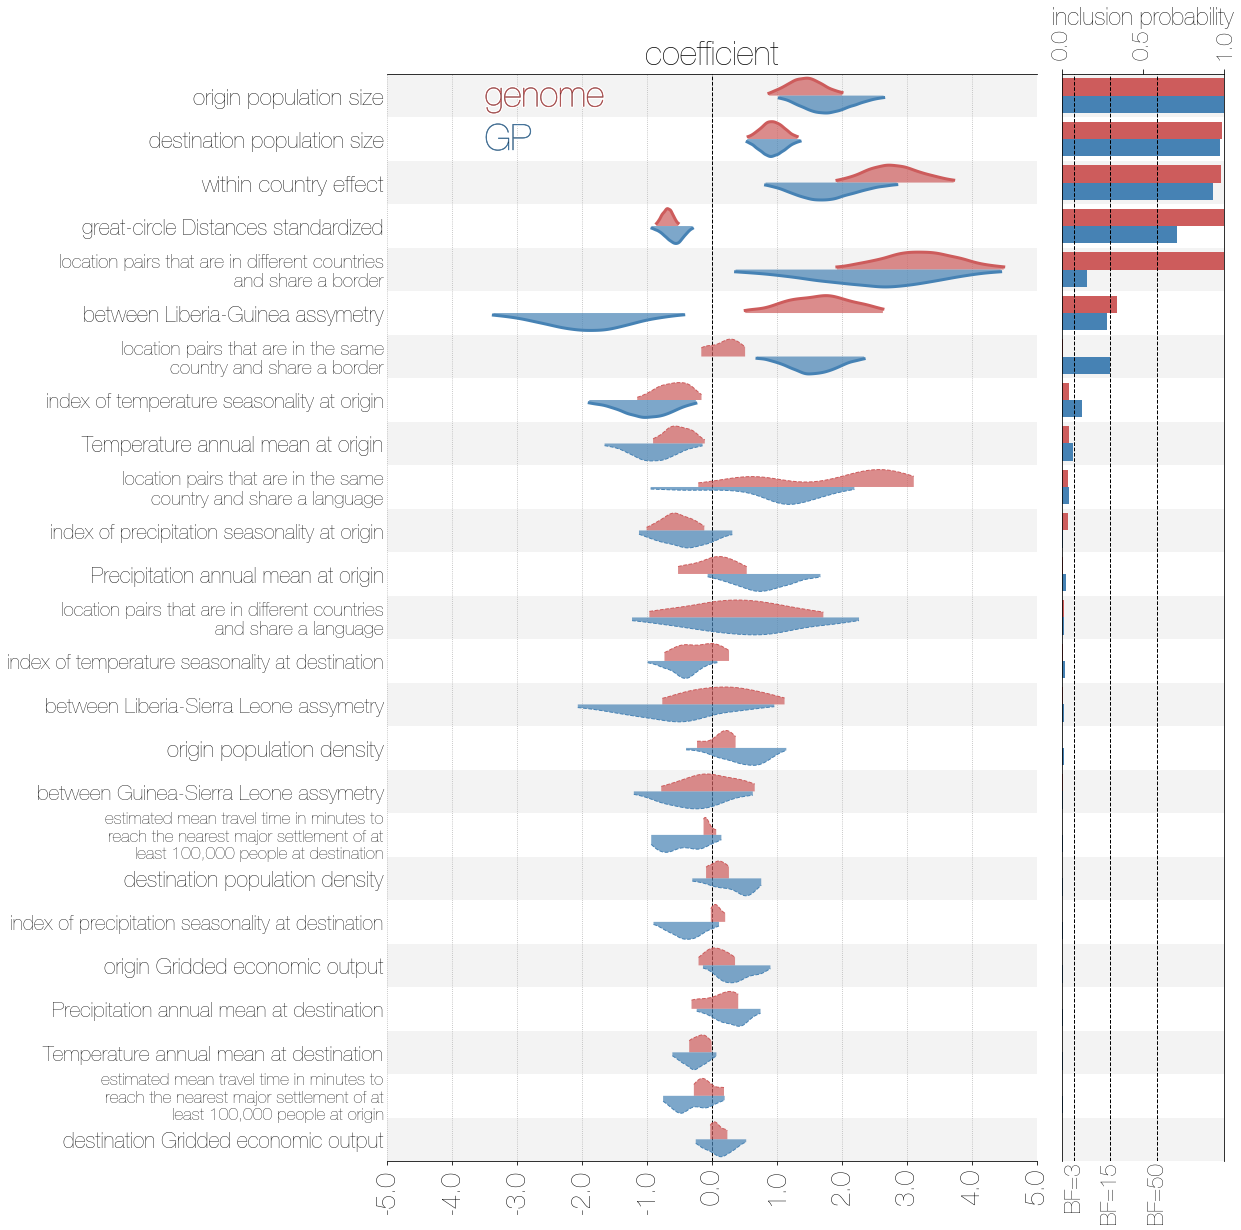

In [19]:
fig = plt.figure(figsize=(15, 20),facecolor='w') 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1],wspace=0.06) ## setup figure with two columns

ax = plt.subplot(gs[0]) ## violins go into this subplot
ax2 = plt.subplot(gs[1]) ## horizontal inclusion probability bars go into this subplot

leftedge=0 ## these will provide x axis limits later on
rightedge=0

ax2.set_xlabel('inclusion probability',size=24) ## set x labels for both figures
ax.set_xlabel('coefficient',size=34)

ax2.xaxis.set_label_position('top')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad=10

plotBFs=[3,15,50] ## plot inclusion probabilities for BF=3, 15 and 50
cutoffs={}
for bf in plotBFs:
    posteriorOdds=priorOdds*bf
    cutoffs[bf]=posteriorOdds/(1+posteriorOdds)
#     print '%d Bayes factor cut-off = %.4f'%(bf,cutoffs[bf])
    ax2.axvline(cutoffs[bf],color='k',lw=1,ls='--')
    ax2.text(cutoffs[bf],-0.5,'BF=%d'%(bf),size=22,ha='center',va='top',rotation=90)

predictors=sorted(gn_GLM_coeffs.keys(),key=lambda x:(np.mean(gn_GLM_indicators[x]),np.mean(gn_GLM_coeffs[x]))) ## sort predictor names by support, then by coefficient

#significant=[x for x in GLM_conditional_coeffs.keys() if np.mean(GLM_indicators[x])>=priorOdds*min(plotBFs)]
#significant=sorted(significant,key=lambda x:(np.mean(GLM_indicators[x]),np.mean(GLM_coeffs[x])))
#print significant

ylabels=[]

print 'genome entropy: %.3f'%(-sum([np.mean(gn_GLM_indicators[x])*np.log(np.mean(gn_GLM_indicators[x])) for x in gn_GLM_indicators]))
print 'GP entropy: %.3f'%(-sum([np.mean(gp_GLM_indicators[x])*np.log(np.mean(gp_GLM_indicators[x])) for x in gp_GLM_indicators]))


for i,x in enumerate(sorted(gn_GLM_coeffs.keys(),key=lambda q:np.mean(gn_GLM_indicators[q])+np.mean(gp_GLM_indicators[q]))): ## for each predictor plot violins     
    gn_support=np.mean(gn_GLM_indicators[x])
    gp_support=np.mean(gp_GLM_indicators[x])
    
    for s,support in enumerate([gn_support,gp_support]):
        GLM_coeffs=[gn_GLM_coeffs,gp_GLM_coeffs][s]
        GLM_indicators=[gn_GLM_indicators,gp_GLM_indicators][s]
        
        condition_samples=[val for val,ind in zip(GLM_coeffs[x],GLM_indicators[x]) if ind==1.0]
        actual_samples=[val*ind for val,ind in zip(GLM_coeffs[x],GLM_indicators[x])] ## product of coefficient and indicator ("actual rate")
#         else:
#             posterior_samples=GLM_coeffs[x] ## otherwise plot all samples
        
#         print x,s,len(actual_samples),len(set(actual_samples)),len(GLM_coeffs[x]),len(GLM_indicators[x])
        if s==0:
            w=1
        else:
            w=-1
#         for p,posterior_samples in enumerate([condition_samples,actual_samples]):
        for p,posterior_samples in enumerate([condition_samples]):
            if len(set(posterior_samples))>2:
                k1 = gaussian_kde(posterior_samples) #calculates the kernel density

                mu=np.mean(posterior_samples)
                m1,M1=hpd(posterior_samples,0.95) ## get HPDs

#                 if support>=min(cutoffs.values()):
                    #print predictor_description[x]
                MCMClen=1e7
                posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
                BF=posteriorOdds/float(priorOdds)
                if BF>50.0:
                    BF='%15s'%('>50')
                else:
                    BF='%15.2f'%(BF)
    #             print '%s\n%40s\t%.2f [%.2f, %.2f]\t%s\t%.4f'%(predictor_description[x],x,mu,m1,M1,BF,support)

                if m1<=leftedge: ## define new x axis minimum if new HPD is lower than current one
                    leftedge=m1
                if M1>=rightedge:
                    rightedge=M1

                x1 = np.linspace(m1,M1,100)  ## create a range of 100 values between lower and upper HPDs
                v1 = k1.evaluate(x1)  ## evaluate KDEs at each of the 100 values
                v1 = v1/v1.max()*0.4*w ## rescale to fit inside defined violin width

                supportFrac=min([1.0,support/float(min(cutoffs.values()))]) ## ratio of inclusion probability and smallest BF required, limited to 1.0

#                 fcolour=['#B291BD','#9CBD91'][p]
                fcolour=['indianred','steelblue'][s]

                ax.fill_between(x1,[i for q in v1],[i+q for q in v1],facecolor=fcolour,edgecolor='none',alpha=0.7,zorder=100) ## plot violin, colour is desaturated depending on inclusion probability
                if '>' in BF or float(BF)>3.0:
                    ax.plot(x1,[i+q for q in v1],color=fcolour,lw=3,alpha=1,zorder=100) ## plot nice edges for each violin (upper and lower)
                else:
                    ax.plot(x1,[i+q for q in v1],color=fcolour,lw=1,ls='--',alpha=1,zorder=100)
            

            if i%2==0: ## even numbered predictor - add a grey shaded area in the background
                ax.axhspan(i-0.5,i+0.5,facecolor='k',edgecolor='none',alpha=0.025,zorder=0)
                ax2.axhspan(i-0.5,i+0.5,facecolor='k',edgecolor='none',alpha=0.025,zorder=0)

            ax2.barh(i+w*0.2,support,height=0.4,lw=2,align='center',edgecolor='none',
                         facecolor=['indianred','steelblue'][s]) ## plot inclusion probability

    
    break_at=7
    desc=predictor_description[x] ## description of predictor
    
    if len(desc.split(', +1'))>1: ## rectify description of predictor matrices
        description=''.join(desc.split(', +1')[:-1])
    elif len(desc.split('pseudo'))>1:
        description=''.join(desc.split(', pseudo')[:-1])
    elif len(desc.split('ln-'))>1:
        description=''.join(desc.split(', ln')[:-1])
    elif len(desc.split(',  0'))>1:
        description=''.join(desc.split(',  0')[:-1])
    else:
        description=desc
    
    break_description='\n'.join([' '.join([y for y in description.split(' ')[x:x+break_at]]) for x in range(0,len(description.split(' ')),break_at)]) ## breaks up the description into new lines to fit nicely
    
    if r'%s'%(break_description) not in ylabels: ## add to y axis labels if not already there
        ylabels.append(r'%s'%(break_description))

for idx in [0,1]:
    if idx==0:
        label='genome'
        c='indianred'
    else:
        label='GP'
        c='steelblue'
        
    effects=[path_effects.Stroke(linewidth=3, foreground='white'),
                     path_effects.Stroke(linewidth=0.5, foreground=c)]
    ax.text(0.15,0.97-idx*0.04,label,size=36,path_effects=effects,transform=ax.transAxes)
    
ax.axvline(0,ls='--',lw=1,color='k') ## add a horizontal line to main plot at coeff=0
ax.grid(axis='x',ls=':')

ax.spines['right'].set_color('none') ## make plot pretty
ax.spines['left'].set_color('none')

ax.yaxis.tick_left()

ax.set_yticks(np.arange(0,len(predictors)))
ax.set_yticklabels(ylabels,size=20)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

for tick in ax.get_yticklabels():
    tick.set_size(34-np.log10(len(list(tick.get_text())))*8)

ax2.xaxis.tick_top()
ax2.set_xticks(np.linspace(0,1,3))
ax2.set_xticklabels(np.linspace(0,1,3),rotation=90)
ax2.tick_params(axis='y',size=0)
ax2.set_yticklabels([])
ax2.tick_params(axis='x',size=5,labelsize=22,direction='out',pad=10)

# ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

ax.tick_params(axis='x',labelsize=26,direction='out')
ax.tick_params(axis='y',size=0)

ax.set_ylim(-0.5,len(predictors)-0.5)
ax2.set_ylim(-0.5,len(predictors)-0.5)
ax.set_xlim(-5,5)
ax2.set_xlim(0,1)

plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/fig4_glm.png',dpi=100,bbox_inches='tight')
plt.show()

In [20]:
timeline=[]
tips=[]

# ancestry={gene:{tip:{t:[] for t in timeline} for tip in tips} for gene in ['genome','gp']}
ancestry={}
burnin=50000000
ancestry={'genome':{},'gp':{}}
for gene in ['genome','gp']:

    path='/Users/evogytis/Documents/manuscripts/genomic-horizon/data/xml/combined/Makona_600_%s.GLM.combined.ancestry.log'%(gene)
    indices={}
    for line in open(path,'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header={x:i for i,x in enumerate(l) if x!='state'}
            header=l[1:]

            for e,entry in enumerate(header):
                cerberus=re.search('([A-Za-z\|\_\.\-0-9]+)\_([0-9\.]+)$',entry)
                tip=cerberus.group(1)
                timeslice=cerberus.group(2)

                if tip not in indices:
                    indices[tip]={}

                if timeslice not in indices[tip]:
                    indices[tip][timeslice]=e+1

                if timeslice not in timeline:
                    timeline.append(timeslice)
                if tip not in tips:
                    tips.append(tip)

                timeline=sorted(timeline,key=lambda x:float(x))

            if len(ancestry[gene])==0:
                ancestry[gene]={leaf:{tp:[] for tp in timeline} for leaf in tips}

        else:
            l=np.array(l)
#                 print len(l)
            for timeslice in timeline:
                for leaf in tips:
                    ancestry[gene][leaf][timeslice].append(l[indices[leaf][timeslice]])

    print [max([len(ancestry[gene][tip][timeslice]) for timeslice in timeline]) for tip in tips]

[4329, 4329, 4329, 4329]
[45588, 45588, 45588, 45588]


EBOV|14859_EMLK|KU296438|SLE|Kambia|2015-04-30


/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


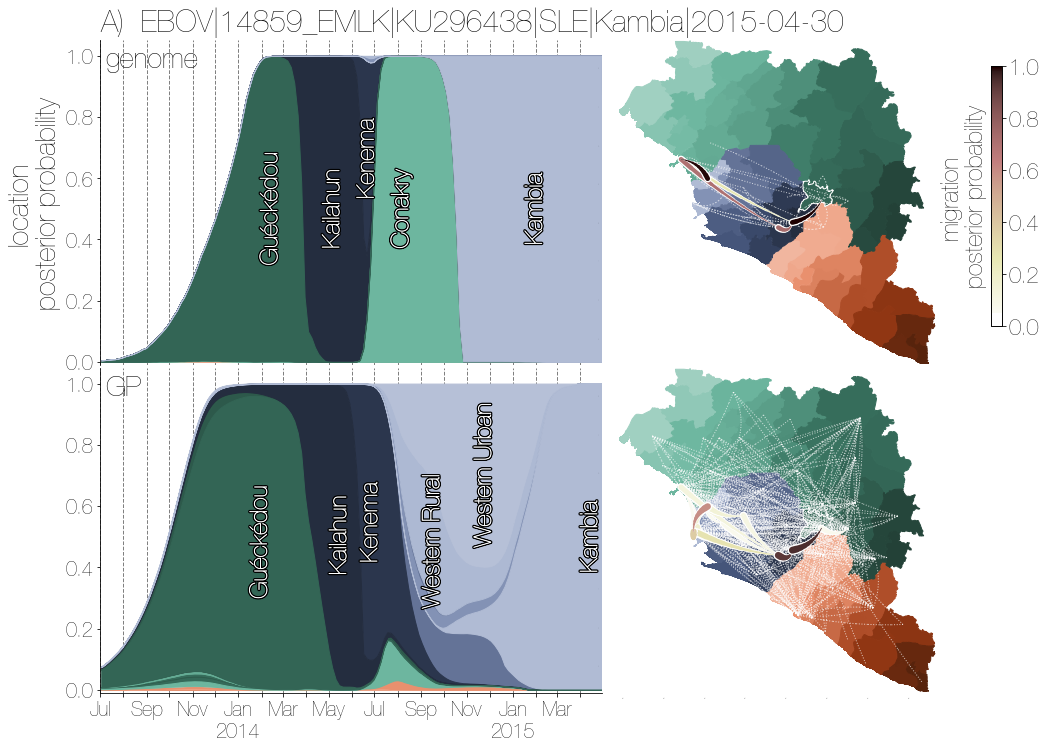

EBOV|EM_004422|KR817097|GIN|Kissidougou|2015-01-02


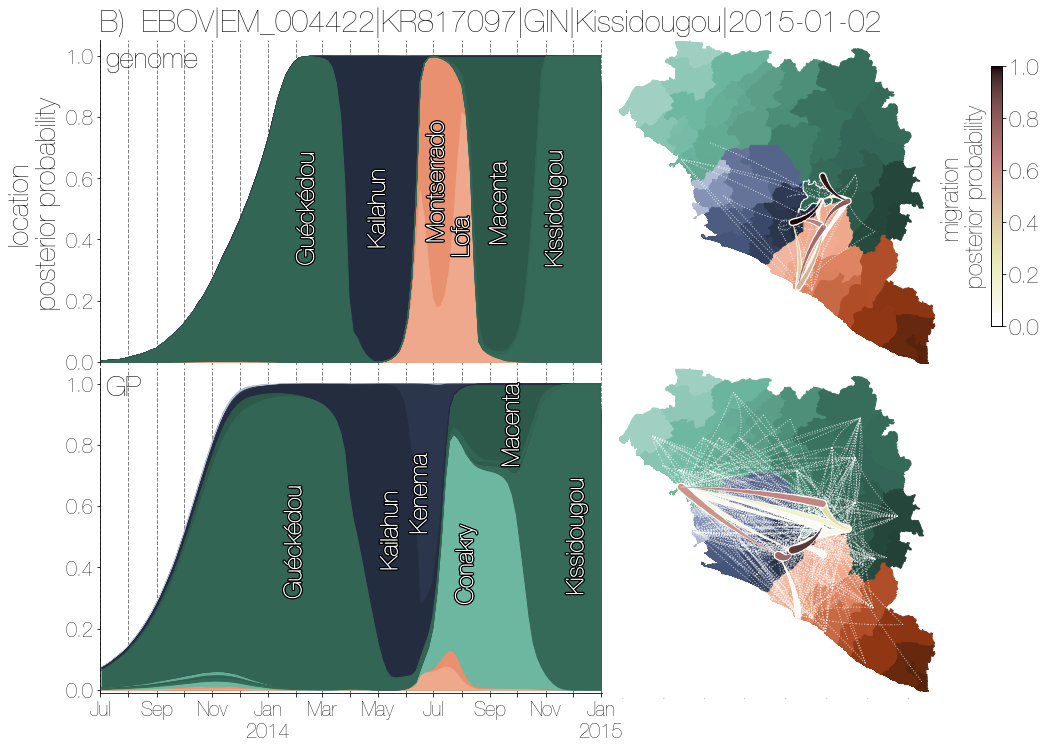

EBOV|MK3462|KU296565|SLE|Bombali|2015-03-26


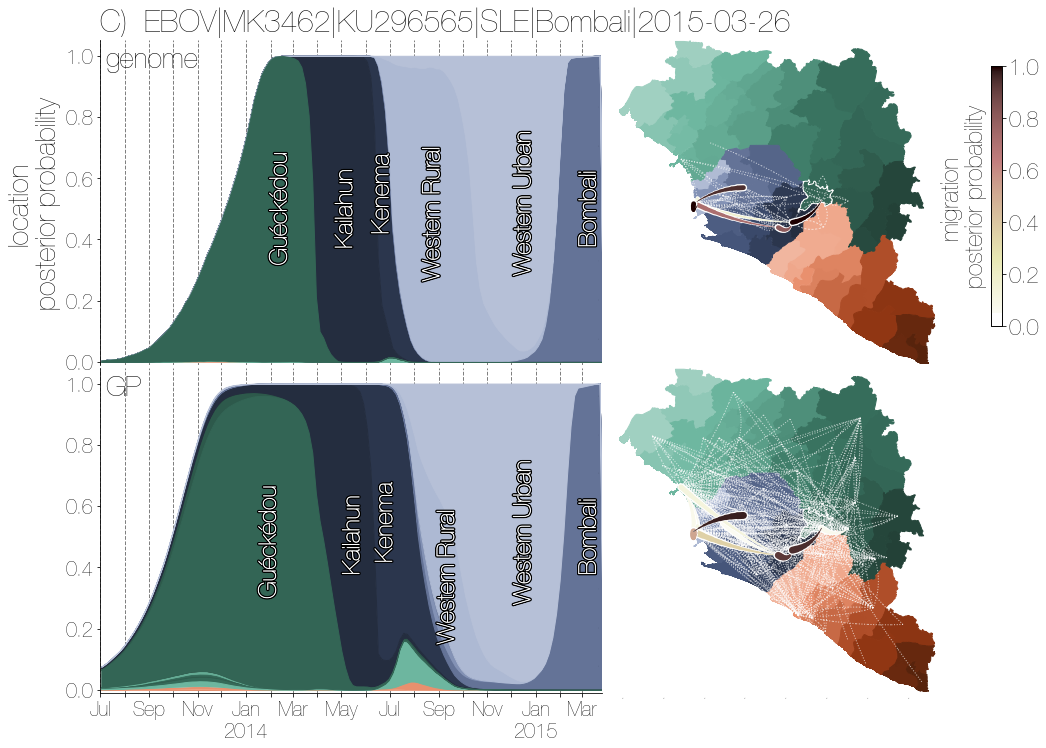

EBOV|PL5294|KU296764|SLE|Kambia|2015-03-24


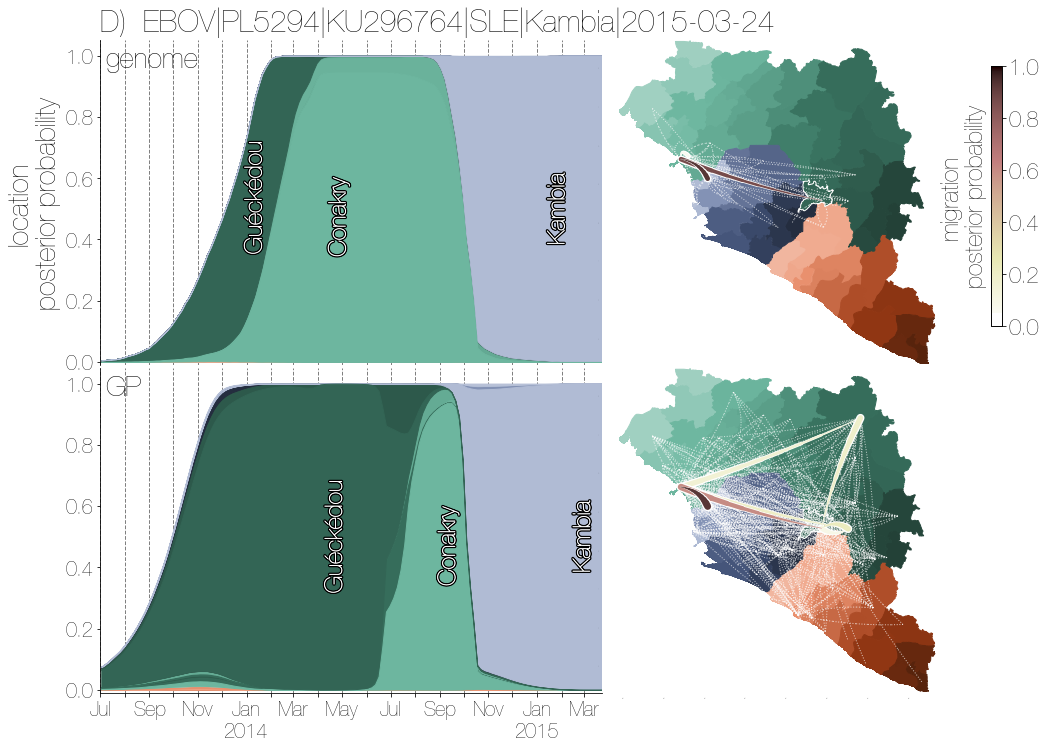

In [21]:
history={}
for tip_idx,tip in enumerate(sorted(ancestry[gene])): ## tip
    print tip
    fig = plt.figure(figsize=(15, 12),facecolor='w') 
    gs = gridspec.GridSpec(2, 2,width_ratios=[9,6],wspace=0.0,hspace=0.01) ## setup figure with two columns
    
    for g,gene in enumerate(['genome','gp']): ## alignment
        if gene=='gp':
            aln=gene.upper()
        else:
            aln=gene
            
        ax = plt.subplot(gs[g,0])
        ax1 = plt.subplot(gs[g,1])
        
        stack=[]
        for tp in timeline: ## timepoint
            locs=[locations[int(i)] for i in ancestry[gene][tip][tp] if i!='None']
            mcmclen=len(ancestry[gene][tip][tp])
            prob_area=[locs.count(loc)/float(mcmclen) if locs.count(loc)>0 else 0.0 for loc in locations]
            stack.append(prob_area)
        
        trajectory=np.array(stack).T
        for l,loc in enumerate(locations):
            if max(trajectory[l])>=0.2:
                idx=np.argmax(trajectory[l])
                x=float(timeline[idx])
                y=sum(trajectory[:l,idx])
                ha='center'
                va='center'
                effects=[path_effects.Stroke(linewidth=3, foreground='k'),
                 path_effects.Stroke(linewidth=0.5, foreground='w')] ## black text, white outline
                
                if loc==tip.split('|')[4]:
                    ha='right'
                    
                if y+trajectory[l][idx]>0.99 and trajectory[l][idx]<0.5:
                    va='top'
                    y+=trajectory[l][idx]/2.0
#                 ax.text(x,y+trajectory[l][idx]/2.0,map_to_actual[loc],size=24,rotation=90,
#                         ha=ha,va=va,path_effects=effects)
                ax.text(x,y+trajectory[l][idx]/2.0,map_to_actual[loc],size=24,rotation=90,
                        ha=ha,va=va,color='w',path_effects=effects,zorder=1000000)
        
        stack=ax.stackplot(map(float,timeline),trajectory,
                           labels=locations,edgecolor='slategrey',lw=1,**{'zorder':1000})
        for p,pols in enumerate(stack):
            pols.set_facecolor(colours[pols.get_label()])
            pols.set_edgecolor(colours[pols.get_label()])
            pols.set_zorder(sum(trajectory[p]))
        
        ax.tick_params(axis='x',labelsize=26)
        ax.tick_params(axis='y',labelsize=20)
        ax.text(0.01,0.98,aln,size=28,va='top',transform=ax.transAxes)
        if g==0:
            ax.text(0.0,1.03,'%s)  %s'%('ABCD'[tip_idx],tip),size=30,transform=ax.transAxes)
            ax.tick_params(axis='x',size=0,labelsize=0)
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
        
        timelabels=['201%d-%02d-01'%(y,m) for y in range(2,6) for m in range(1,13)]
        ax.set_xticks(map(bt.decimalDate,timelabels))
        [ax.axvline(t,color='grey',ls='--',lw=1,zorder=0) for t in ax.get_xticks()]
        if g==1:
            ax.set_xticklabels([(bt.convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else bt.convertDate(x,'%Y-%m-%d','%b')) if (1+int(x.split('-')[1]))%2==0 else '' for x in timelabels],size=20)
            [ax.spines[edge].set_visible(False) for edge in ['top','right']]
        else:
            ax.set_ylabel('location\nposterior probability',size=28)
            ax.set_xticklabels([])
            [ax.spines[edge].set_visible(False) for edge in ['top','bottom','right']]
        
        ax.set_xlim(bt.decimalDate('2013-07-01'),bt.decimalDate(tip.split('|')[-1]))
        ax.set_ylim(-0.01,1.05)
        
        ##### MAP BEGINS HERE
        all_pairs={(locA,locB):0 for locB in locations for locA in locations if locA!=locB}            
    
        for t,tp in enumerate(timeline[:-1]): ## timepoint
            tn=timeline[t+1]
            mcmclen=float(len(ancestry[gene][tip][tp]))
            migrations=[(locations[int(ori)],locations[int(des)]) for ori,des in zip(ancestry[gene][tip][tp],ancestry[gene][tip][tn]) if ori!=des and ori!='None' and des!='None']
            
            for pair in migrations:
                all_pairs[pair]+=1
                
        for pair in all_pairs:
            post=np.clip(all_pairs[pair]/mcmclen,0.0,1.0)
            if post>0.0:
                ori,des=pair
                oriX,oriY=popCentres[ori]
                desX,desY=popCentres[des]

                distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))
                adjust_d=2/float(distance)**0.15-0.5

                c=Bezier_control(popCentres[ori],popCentres[des],adjust_d/7.0,0.5)
                curve = bz.Curve(np.asfortranarray([popCentres[ori],c,popCentres[des]]).T,degree=2)

                cmap=mpl.cm.pink_r
                N=np.linspace(0,1,10)
#                 coords=curve.evaluate_multi(N)
                xs,ys=curve.evaluate_multi(N)
#                 for q in range(len(coords)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                for q in range(len(xs)-1):
#                     x1,y1=coords[q] ## coordinates of current point
#                     x2,y2=coords[q+1] ## coordinates of next point
                    x1,y1=xs[q],ys[q]
                    x2,y2=xs[q+1],ys[q+1]
                    if post>0.05:
                        segL=(q+1)/float(len(xs)) ## fraction along length of Bezier line
                        lw=np.log(all_pairs[pair]/20.0)
                        fc=cmap(post)
                        al=1.0
                        z=all_pairs[pair]
                        ls='-'
                        ax1.plot([x1,x2],[y1,y2],lw=(lw+3)*segL,alpha=1.0,color='w',zorder=z-1,solid_capstyle='round') ## plot white outline underneath
                    else:
                        segL=1
                        lw=1
                        fc='w'
                        al=0.7
                        z=3
                        ls=':'

                    ax1.plot([x1,x2],[y1,y2],lw=lw*segL,alpha=al,color=fc,zorder=z,ls=ls,solid_capstyle='round') ## plot actual lineage with width proportional to position along Bezier curve

        for loc in locations:
            if loc in polygons:
                fc=colours[loc]
                ec=fc
                z=0
                if loc=='Gueckedou':
                    ec='w'
                    z=1
                ax1.add_collection(PatchCollection(polygons[loc],facecolor=fc,edgecolor=ec,zorder=z))
        [ax1.spines[edge].set_visible(False) for edge in ['top','bottom','left','right']]
        ax1.tick_params(size=0,labelsize=0) ## no ticks
        
        axcb = fig.add_axes([0.95, 0.55, 0.01, 0.3], frame_on=False)
        cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=mpl.colors.Normalize(vmin=0.0,vmax=1.0),alpha=1.0,drawedges=False)
        cb.ax.add_patch(plt.Rectangle((0.0,0.0),1.0,0.05,facecolor='w',edgecolor='none'))
        cb.ax.tick_params(labelsize=22)
        cb.ax.yaxis.set_label_position('left')
        cb.ax.set_ylabel('migration\nposterior probability',size=24)
        ax1.set_xlim(-15.5,-7.3)
        ax1.set_ylim(4.3,12.7)
        
    plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/figures/figX%s_histories.png'%('ABCD'[tip_idx]),dpi=300,bbox_inches='tight')
    plt.show()

# EBOV|PL5294|KU296764|SLE|Kambia|2015-03-24 Kambia	Kambia	Coyah	Coyah	Coyah	Coyah	Coyah	Coyah	Gueckedou	Gueckedou	Gueckedou	Gueckedou	Gueckedou	WesternUrban

EBOV|14859_EMLK|KU296438|SLE|Kambia|2015-04-30


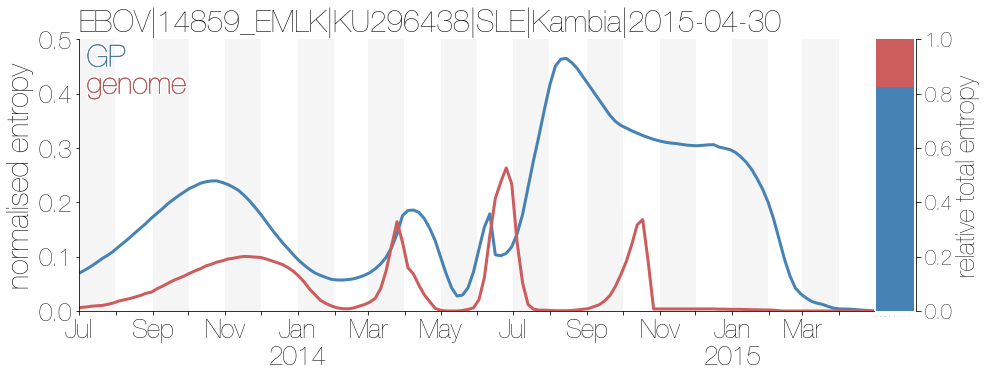

EBOV|EM_004422|KR817097|GIN|Kissidougou|2015-01-02


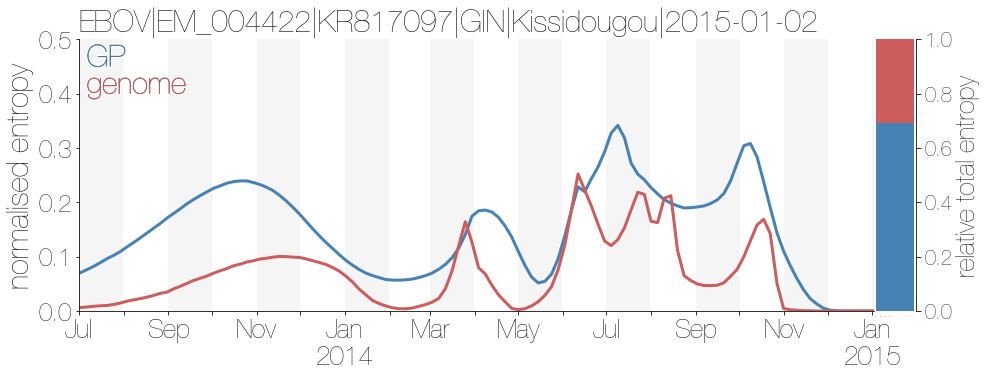

EBOV|MK3462|KU296565|SLE|Bombali|2015-03-26


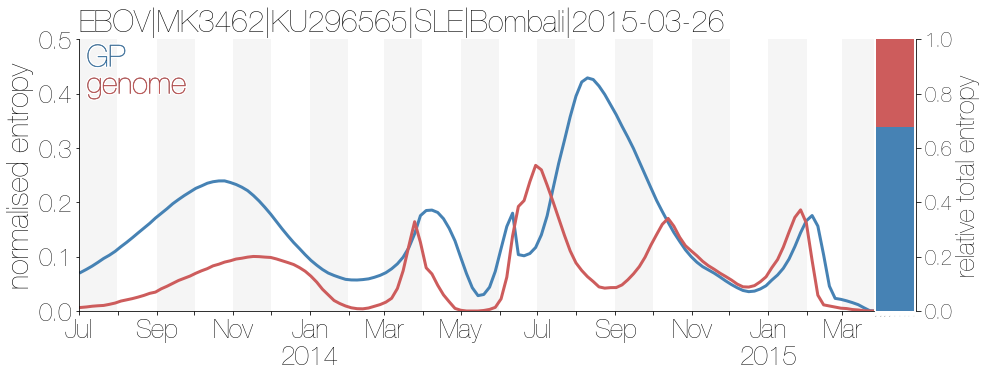

EBOV|PL5294|KU296764|SLE|Kambia|2015-03-24


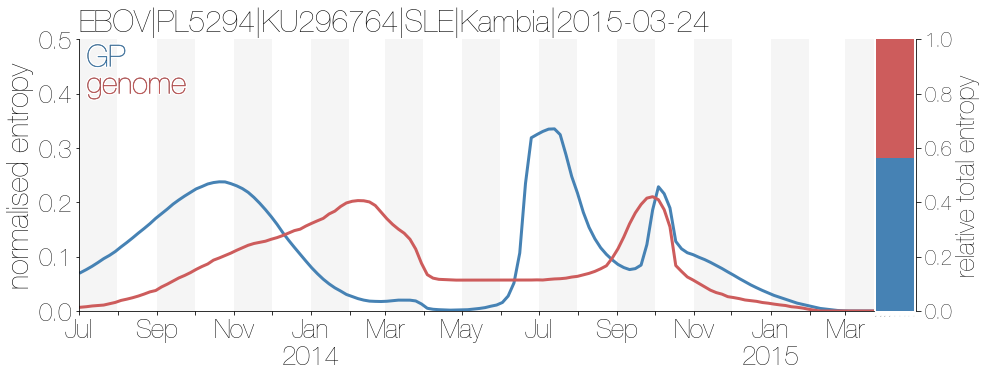

In [22]:
for tip_idx,tip in enumerate(sorted(ancestry[gene])): ## tip
    print tip
    fig = plt.figure(figsize=(15, 5),facecolor='w') 
    gs = gridspec.GridSpec(1, 2,width_ratios=[95,5],wspace=0.0,hspace=0.01) ## setup figure with two columns
    ax = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    entropies=[0.0,0.0]
    for g,gene in enumerate(['gp','genome']): ## alignment
        if gene=='gp':
            aln=gene.upper()
            c='steelblue'
        else:
            aln=gene
            c='indianred'
        
        effects=[path_effects.Stroke(linewidth=3, foreground='white'),
                         path_effects.Stroke(linewidth=0.5, foreground=c)]
        ax.text(0.01,0.9-g*0.1,aln,size=30,path_effects=effects,transform=ax.transAxes)
        
        stack=[]
        for tp in timeline: ## timepoint
            locs=[locations[int(i)] for i in ancestry[gene][tip][tp] if i!='None']
            mcmclen=len(ancestry[gene][tip][tp])
            prob_area=[locs.count(loc)/float(mcmclen) if locs.count(loc)>0 else 0.0 for loc in locations]
            stack.append(prob_area)
        
        trajectory=np.array(stack).T
        locs=[loc for loc in locations if location_to_country[loc] in ['SLE','GIN','LBR']]
        entropy=[sum([-p*np.log2(p)/np.log2(len(locations)) for p in stack[l] if p>0.0]) for l in range(len(stack))]
        entropies[g]=sum(entropy)
        ax.plot(map(float,timeline),entropy,color=c,lw=3)
    
    ax.tick_params(axis='x',labelsize=26)
    ax.tick_params(axis='y',labelsize=24)
    ax.text(0.0,1.03,tip,size=30,transform=ax.transAxes)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
    
    timelabels=['201%d-%02d-01'%(y,m) for y in range(2,6) for m in range(1,13)]
    ax.set_xticks(map(bt.decimalDate,timelabels))

    ax.set_xticklabels([(bt.convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else bt.convertDate(x,'%Y-%m-%d','%b')) if (1+int(x.split('-')[1]))%2==0 else '' for x in timelabels])
    [ax.spines[edge].set_visible(False) for edge in ['top','right']]
        
    ax.set_ylabel('normalised entropy',size=30)
    ax.set_xlim(bt.decimalDate('2013-07-01'),bt.decimalDate(tip.split('|')[-1]))
    ax.set_ylim(0,0.5)
    [ax.axvspan(bt.decimalDate(timelabels[x]),bt.decimalDate(timelabels[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(timelabels),2)] ## grey vertical bar every second month
    
    entropies=[entropy/sum(entropies) for entropy in entropies]
    for e,entropy in enumerate(entropies):
        ax1.bar(0.0,entropy,bottom=sum(entropies[:e]),color=['steelblue','indianred'][e])
    [ax1.spines[edge].set_visible(False) for edge in ['top','bottom','left']]
    ax1.tick_params(axis='x',size=0,labelsize=0)
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position('right')
    ax1.set_ylabel('relative total entropy',size=26)
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    ax1.tick_params(axis='y',size=5,labelsize=20)
    ax1.set_ylim(0,1)
    
    plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/supp_figures/sfigX%s_locationEntropy.png'%('ABCD'[tip_idx]),dpi=300,bbox_inches='tight')
    plt.show()

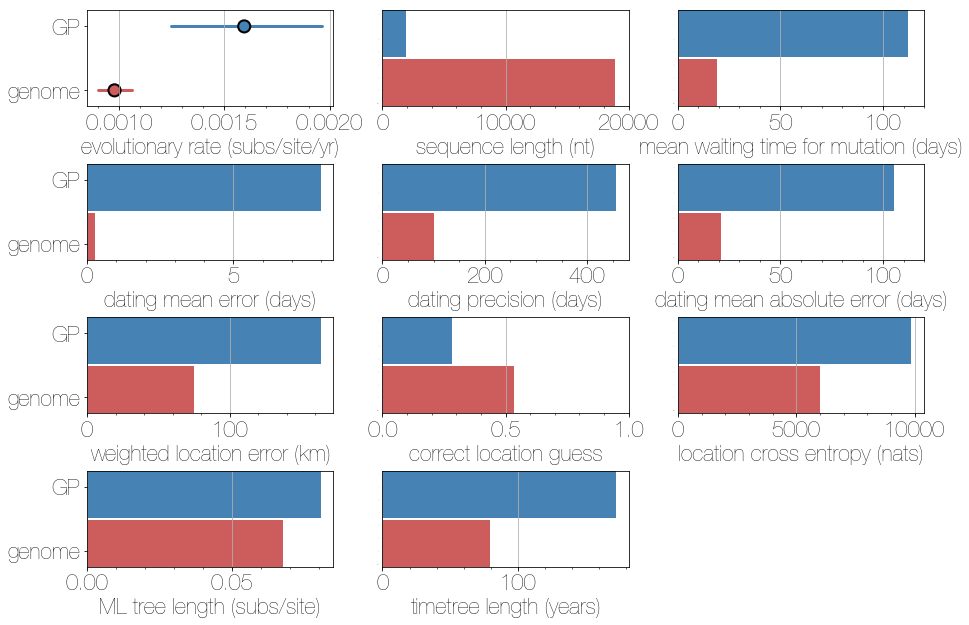

In [23]:
fig = plt.figure(figsize=(15, 30),facecolor='w') 
gs = gridspec.GridSpec(len(summary['genome'])-2, 3,wspace=0.2,hspace=0.6) ## setup figure with two columns

stats=['rate','length','expected waiting time for mutation',
       'mean error','precision','mean absolute error',
       'weighted location error','correct location guess',
       'location cross entropy','ML tree length','timetree length']

units={'rate':'subs/site/yr',
       'length':'nt',
       'expected waiting time for mutation':'days',
       'mean error':'days',
       'mean absolute error':'days',
       'precision':'days',
       'weighted location error':'km',
       'location cross entropy':'nats',
       'ML tree length':'subs/site',
       'timetree length':'years'}

labels={'rate':'evolutionary rate',
       'length':'sequence length',
       'expected waiting time for mutation':'mean waiting time for mutation',
       'mean error':'dating mean error',
       'mean absolute error':'dating mean absolute error',
       'precision':'dating precision',
       'weighted location error':'weighted location error',
       'location cross entropy':'location cross entropy',
       'correct location guess':'correct location guess',
       'ML tree length':'ML tree length',
       'timetree length':'timetree length'}


for s,stat in enumerate(stats):
    if '95' not in stat:
        ax = plt.subplot(gs[s])
        ax.set_xlabel('%s (%s)'%(labels[stat],units[stat]) if stat in units else labels[stat])
            
        for a,aln in enumerate(summary):
            colour='indianred' if aln=='genome' else 'steelblue'
            if stat=='rate':
                ax.plot([summary[aln]['rate upper 95\% HPD'],summary[aln]['rate lower 95\% HPD']],[a,a],color=colour,zorder=0,lw=3,solid_capstyle='round')
            
            if stat not in ['rate']:
                ax.barh(a,summary[aln][stat],1,facecolor=colour,edgecolor='w',lw=2,align='center')
            else:
                ax.scatter(summary[aln][stat],a,s=100,facecolor=colour,edgecolor='none',zorder=2)
                ax.scatter(summary[aln][stat],a,s=200,facecolor='k',edgecolor='none',zorder=1)
                
            if stat=='length':
                ax.set_xlim(0,20001)
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2000))
            elif stat=='mean error':
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
            elif stat in ['timetree length','weighted location error']:
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
            elif stat=='correct location guess':
                ax.set_xlim(0,1)
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            elif stat=='ML tree length':
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
            elif stat=='rate':
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.0001))
            elif stat=='precision':
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
            elif stat in ['mean absolute error','expected waiting time for mutation']:
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
                ax.set_xlim(0,120)
            elif stat=='location cross entropy':
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1000))
                
    ax.grid(axis='x')
            
    if s%3==0:
        ax.set_yticks(range(len(summary)))
        ax.set_yticklabels([x.upper() if x=='gp' else x for x in summary])
    else:
        ax.tick_params(axis='y',size=0,labelsize=0)
        
    ax.set_ylim(-0.25,1.25)
    
plt.savefig('/Users/evogytis/Documents/manuscripts/genomic-horizon/supp_figures/sfigX_summary.png',dpi=300,bbox_inches='tight')  
plt.show()